In [215]:
import tensorflow as tf
import os

In [216]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [217]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [218]:
import cv2
import imghdr

In [219]:
data_dir = 'mobile' 

In [220]:
image_exts = ['jpeg','jpg','bmp', 'png']

In [221]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [222]:
import numpy as np
from matplotlib import pyplot as plt

In [223]:
data = tf.keras.utils.image_dataset_from_directory('mobile')

Found 198 files belonging to 2 classes.


In [224]:
data_iterator = data.as_numpy_iterator()

In [225]:
data_iterator

In [226]:
batch= data_iterator.next()

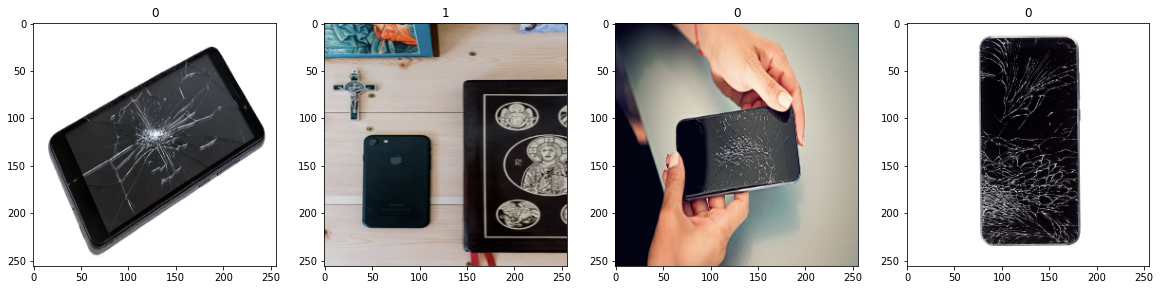

In [227]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [228]:
data = data.map(lambda x,y: (x/255, y))

In [229]:
len(data)

7

In [230]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [231]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [232]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [233]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [234]:
model = Sequential()

In [235]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [236]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [237]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

In [238]:
logdir='logs'

In [239]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [253]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
4/4 [==============================] - 2s 392ms/step - loss: 0.0286 - accuracy: 0.9922 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 2s 382ms/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 2s 386ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 2s 374ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 2s 368ms/step - loss: 0.0183 - accuracy: 0.9922 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 2s 414ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 2s 361ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 8/10
4/4 [====

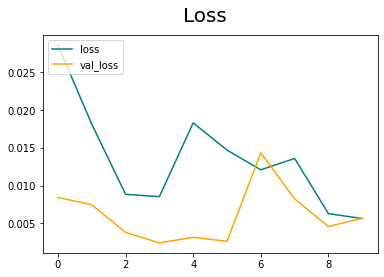

In [254]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

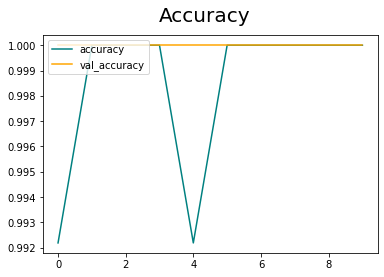

In [255]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [256]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [257]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [258]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [259]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [260]:
import cv2

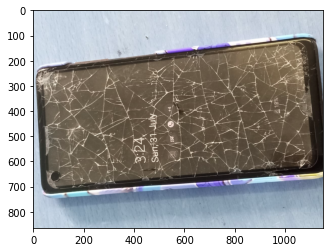

In [266]:
img = cv2.imread('mobiletest/WhatsApp Image 2022-07-31 at 3.24.17 PM.jpeg')
plt.imshow(img)
plt.show()

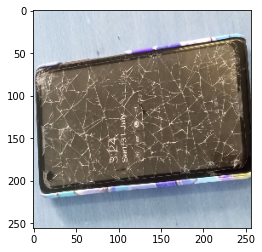

In [267]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [268]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 20ms/step


In [269]:
if yhat > 0.2: 
    print(f'Predicted class is Intact')
else:
    print(f'Predicted class is Damaged')

Predicted class is Damaged


In [270]:
yhat

array([[0.00023171]], dtype=float32)